# Traning of ML model for Predicting

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\harsh\OneDrive\Desktop\data analysis\AI powered supply chain esg and risk optimizatoin\cleaned_data\features_model.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Supplier_ID,Supplier_Name,Stock_levels,Lead_times,Shipping_times,Manufacturing_costs,Delivery_Reliabiliy,OnTime_Flag,Cost_per_unit,Revenue_per_unit,Stockout_Risk,Inspection_failure_flag,Total ESG Risk score,Governance Risk Score,Controversy Score,ESG Risk Level,ESG_Risk_Level_Encoded,GPR_Index
0,0,0,S0043,SUPP_I_043,2937.0,19.0,8.0,207056.53,2.375,1,14.116207,13.7267,0.0,0,12.6,5.6,4.0,Low,1.0,10.35
1,1,1,S0043,SUPP_I_043,2937.0,19.0,8.0,207056.53,2.375,1,14.116207,13.7267,0.0,0,34.1,15.8,2.0,High,3.0,10.35
2,2,2,S0224,SUPP_CD_224,2370.0,14.0,8.0,114319.67,1.750,1,17.294958,27.1266,0.0,0,28.0,6.2,2.0,Unknown,0.0,10.35
3,3,3,S0224,SUPP_CD_224,2370.0,14.0,8.0,114319.67,1.750,1,17.294958,27.1266,0.0,0,28.0,6.2,2.0,Unknown,0.0,10.35
4,4,4,S0224,SUPP_CD_224,2370.0,14.0,8.0,114319.67,1.750,1,17.294958,27.1266,0.0,0,23.4,6.2,2.0,Medium,2.0,10.35


In [53]:
df['OnTime_Flag'].value_counts()

df.to_csv(r'C:\Users\harsh\OneDrive\Desktop\data analysis\AI powered supply chain esg and risk optimizatoin\cleaned_data\features_model.csv')

In [ ]:
# Encode ESG Risk Level feature
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = le.fit_transform(df[col].astype(str)) 


### OnTime_flag alone not giving good results , created a more business_relavant risk flag:


In [35]:
df['Risk_Flag'] = (
    (df['OnTime_Flag'] == 0) | 
    (df['Total ESG Risk score'] > 40) | 
    (df['GPR_Index'] > df['GPR_Index'].median())
).astype(int)

In [36]:
df['Risk_Flag'].value_counts()

Risk_Flag
0    6491
1    6094
Name: count, dtype: int64

In [38]:
# use Risk_flag as Target feature

X = df[['Stock_levels',
 'Lead_times',
 'Shipping_times',
 'Manufacturing_costs',
 'Delivery_Reliabiliy',
 'Cost_per_unit',
 'Revenue_per_unit',
 'Stockout_Risk',
 'Inspection_failure_flag',
 'Governance Risk Score',
 'Controversy Score',
 'ESG_Risk_Level_Encoded']]
 
y = df['Risk_Flag']

X_train , X_test , y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:


rf = RandomForestClassifier(n_estimators=200,random_state=42,class_weight='balanced')
rf.fit(X_train,y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [40]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("Classification Report")
print(classification_report(y_test,y_pred))
print("ROC-AUC",roc_auc_score(y_test,y_prob))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1957
           1       0.95      0.94      0.94      1819

    accuracy                           0.94      3776
   macro avg       0.94      0.94      0.94      3776
weighted avg       0.94      0.94      0.94      3776

ROC-AUC 0.9911526910488645


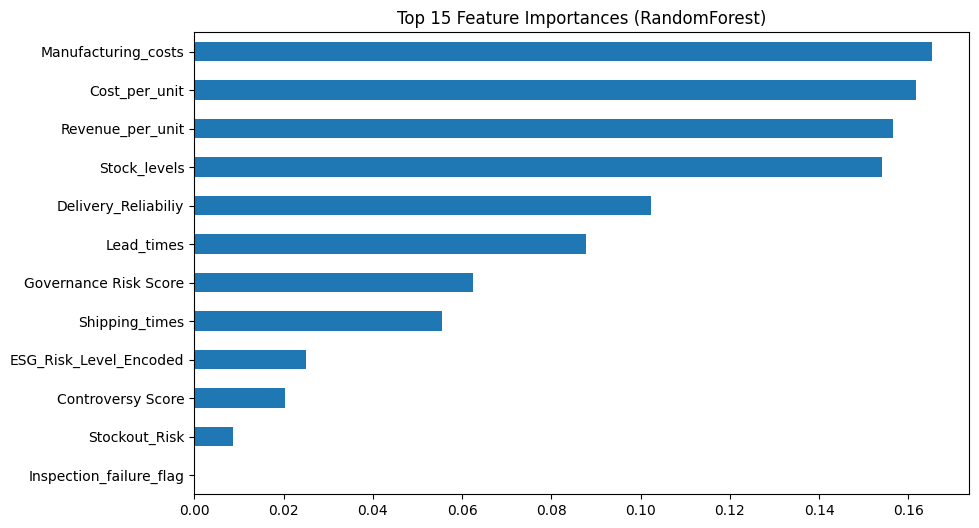

In [41]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (RandomForest)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
 #Example: pick one supplier row from your dataframe
sample_supplier = df.iloc[[0]]   

# Drop target and leakage columns to match training features
sample_features = sample_supplier.drop(columns=['Supplier_ID', 'Supplier_Name', 'Risk_Flag','ESG Risk Level',
 'GPR_Index','OnTime_Flag','Total ESG Risk score','Unnamed: 0'])

# Predict using trained model
pred_class = rf.predict(sample_features)          # 0 or 1
pred_prob  = rf.predict_proba(sample_features)    # probabilities for both classes

print(f"Supplier_ID: {sample_supplier['Supplier_ID'].values[0]}")
print(f"Predicted Class (0=Not Risky, 1=Risky): {pred_class[0]}")
print(f"Probability of Risk: {pred_prob[0][1]:.2f}")

Supplier_ID: S0043
Predicted Class (0=Not Risky, 1=Risky): 1
Probability of Risk: 0.56


In [46]:
df.columns

Index(['Unnamed: 0', 'Supplier_ID', 'Supplier_Name', 'Stock_levels',
       'Lead_times', 'Shipping_times', 'Manufacturing_costs',
       'Delivery_Reliabiliy', 'OnTime_Flag', 'Cost_per_unit',
       'Revenue_per_unit', 'Stockout_Risk', 'Inspection_failure_flag',
       'Total ESG Risk score', 'Governance Risk Score', 'Controversy Score',
       'ESG Risk Level', 'ESG_Risk_Level_Encoded', 'GPR_Index', 'Risk_Flag'],
      dtype='object')

In [ ]:


#  Step 1: Predict risk probability per transaction
# Assuming you already have a trained model (e.g., model_xgb) and feature set X
df['Risk_Probability'] = rf.predict_proba(X)[:, 1]

#  Step 2: Aggregate by Supplier_ID
supplier_risk = (
    df.groupby(['Supplier_ID', 'Supplier_Name'])
      .agg(
          Avg_Risk_Prob=('Risk_Probability', 'mean'),
          Max_Risk_Prob=('Risk_Probability', 'max'),
          ESG_Risk_Score=('Total ESG Risk score', 'mean'),
          GPR_Index=('GPR_Index', 'mean'),
          Transactions=('Risk_Probability', 'count')
      )
      .reset_index()
)

# Add Supplier Risk Flag (threshold can be tuned, here 0.5)
supplier_risk['Supplier_Risk_Flag'] = (supplier_risk['Avg_Risk_Prob'] > 0.5).astype(int)


supplier_risk.to_csv(r"C:\Users\harsh\OneDrive\Desktop\data analysis\AI powered supply chain esg and risk optimizatoin\cleaned_data\supplier_risk_scores.csv", index=False)

print("Supplier-level risk scores saved as supplier_risk_scores.csv")
print(supplier_risk.head(10)) 


Supplier-level risk scores saved as supplier_risk_scores.csv
  Supplier_ID Supplier_Name  Avg_Risk_Prob  Max_Risk_Prob  ESG_Risk_Score  \
0       S0001    SUPP_I_001       0.474375          0.885           23.35   
1       S0002   SUPP_BM_002       0.404167          0.990           33.40   
2       S0003    SUPP_I_003       0.312188          0.795           23.35   
3       S0004    SUPP_I_004       0.519375          0.930           23.35   
4       S0005    SUPP_E_005       0.875857          1.000           43.95   
5       S0006   SUPP_BM_006       0.551667          1.000           33.40   
6       S0007    SUPP_U_007       0.394833          0.925           39.40   
7       S0008   SUPP_BM_008       0.647667          1.000           33.40   
8       S0009   SUPP_CS_009       0.391000          0.815           19.50   
9       S0010    SUPP_U_010       0.532045          0.960           39.40   

   GPR_Index  Transactions  Supplier_Risk_Flag  
0  32.430000            24                

In [ ]:
########doinnlaaprinta0i2e-1